# Stick or Twist Demo

The purpose of Stick or Twist is to tell ride sharing drivers where the optimal location is for them to wait for a new fare to maximise their revenue.

This notebook details the work done so far on a Python prototype of Stick or Twist

In [1]:
#Set the correct global working directory
import os
current_dir = os.getcwd()
if current_dir[-9:] == "notebooks": 
    os.chdir('..')
print(os.getcwd())

/home/oisin/Development/stick-or-twist-v2


In [2]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from src.data_preprocess.calc_search_time import CalculateSearchTimes
from src.decision_makers.highest_epm import HighestEpm
from src.taxi_environment.taxi_environment import TaxiEnvironment
from src.data_preprocess.transition import Transition
from src.data_preprocess.calc_travel_times import CalculateTravelTimes
from src.data_preprocess.calc_mean_fare import CalculateFare

from datetime import datetime
from src.driver_comparison.driver_comparison import DriverComparison

print("Imports Success!")

Imports Success!


### New York Taxi Dataset
Seems how it is the most extensive resource on trip data we decided  to use a subset of the new york taxi data.

We downloaded the dataset from (link)

Then we cleaned the data and reverse geocoded it to zip codes in new york. These zip codes are roughly 0.18 square miles in area.


In [3]:

data_path = 'data/zips_manhattan.csv'
ny_data_set = pd.read_csv(data_path, skipinitialspace=True)
print("Current dataset contains " + str(len(ny_data_set)) + " trips")
print("")
print("The data set contains the following columns:")

for col in ny_data_set.columns:
    print("   *" + col)

Current dataset contains 1581909 trips

The data set contains the following columns:
   *Unnamed: 0
   *medallion
   *pickup_datetime
   *dropoff_datetime
   *trip_time_in_secs
   *trip_distance
   *pickup_longitude
   *pickup_latitude
   *dropoff_longitude
   *dropoff_latitude
   *fare_amount
   *pickup_zips
   *dropoff_zips


### Choosing Zip codes

We excluded trips with zip codes outside of Manhattan as the data would have become extremely sparse.

There are 33 unique pickup zip codes.
There are 43 unique drop off zip codes.


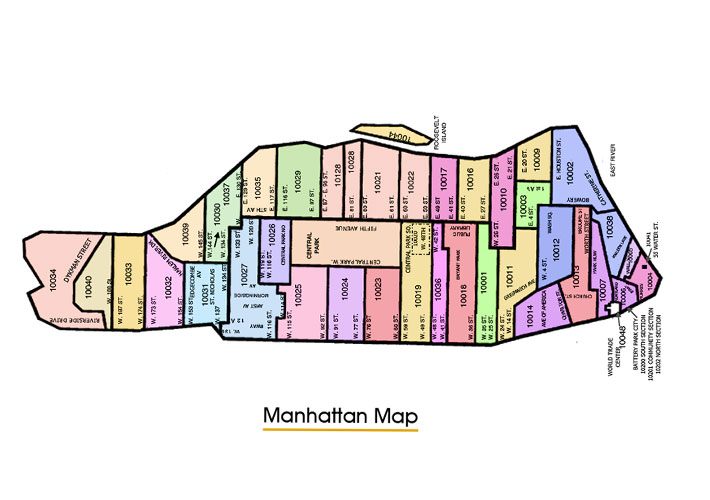

In [4]:
from IPython.display import Image
print("There are " + str(len(ny_data_set['pickup_zips'].unique())) + " unique pickup zip codes.")
print("There are " + str(len(ny_data_set['dropoff_zips'].unique())) + " unique drop off zip codes.")
Image(filename='notebooks/images/manhattan-zipcodemap.jpg') 

#### Inconsistencies

Although we cleaned the data there are still some issues. Mainly the descrepancies between the number of trips per day as shown by the bar plot below. The data is meant to be for a month. More data will need to be aggregated as the number of full days is not currently enough.

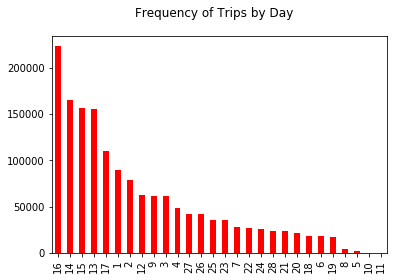

In [5]:
ny_data_set['pickup_datetime'] = pd.to_datetime(ny_data_set['pickup_datetime'])
ny_data_set['day_of_month'] = ny_data_set['pickup_datetime'].apply(lambda x: x.day)

_, ax = plt.subplots()
ny_data_set['day_of_month'].value_counts().plot(ax=ax, kind='bar', color= 'red')
plt.suptitle('Frequency of Trips by Day')
plt.show()


## Simulation

In order to figure out the best places to drive we created a simulation in which a driver chooses zip codes to search in, spends time searching for a customer, drives a customer to their destination and repeats the process until the shift is over.

In [6]:
# Demo Constants
TIME_PERIODS = 6
EXAMPLE_ZIP_CODE = 10026
EXAMPLE_DATETIME = datetime(2013, 1, 15, 12)
EXAMPLE_RAND = 0.3

### Set up of simulation Functions 

3 functions are required to run the simulation. 
* Simulate trip function
* Simulate search time
* Simulate travel time


They are based on calculations generated from a large csv file containing booking data. 
<br>
To save time the calculations are loaded from pickled files, although they can be calculated as required.



In [7]:
# 3 functions needed to run the simulation based on csv data
sim_trip = Transition().simulate_new_dropoff_zone
sim_search_time = CalculateSearchTimes(TIME_PERIODS).stocastic_search
sim_travel_time = CalculateTravelTimes(TIME_PERIODS).simulate_travel_time

##### Simulate trip function
Driver has just made a pickup at a zone at a given time.
<br>
Stocastically returns the new zone the customer is going to based on weights in the dataset.


In [8]:
print("Started in " + str(EXAMPLE_ZIP_CODE))
print("At " + str(EXAMPLE_DATETIME))
new_zone = sim_trip(EXAMPLE_ZIP_CODE, EXAMPLE_DATETIME, EXAMPLE_RAND)
print("Customer wants to drive to " + str(new_zone))


Started in 10026
At 2013-01-15 12:00:00
Customer wants to drive to 10075


##### Simulate search time function
Driver has driven to a zone and is searching for a customer.
<br>
Returns on average how long the driver will be searching that zone

In [9]:
print("Driver drives to " + str(EXAMPLE_ZIP_CODE))
print("At " + str(EXAMPLE_DATETIME))
search_time = sim_search_time(EXAMPLE_ZIP_CODE, EXAMPLE_DATETIME)
print("Driver waits " + str(search_time) + " minutes")

Driver drives to 10026
At 2013-01-15 12:00:00
Driver waits 1926.2497466837635 minutes


##### Simulate travel time
Driver wants to travel between 2 zones.
Returns how long the driver will be driving.

In [10]:
print("Driver at " + str(EXAMPLE_ZIP_CODE) + " wants to drive to " + str(new_zone))
drive_time = sim_travel_time(EXAMPLE_ZIP_CODE, new_zone, EXAMPLE_DATETIME)
print("At " + str(EXAMPLE_DATETIME))
print("This journey takes the driver " + str(drive_time) + " minutes")

Driver at 10026 wants to drive to 10075
At 2013-01-15 12:00:00
This journey takes the driver 14.318520237912516 minutes


In [11]:
print("At " + str(EXAMPLE_DATETIME))
search_time = sim_search_time(10028, EXAMPLE_DATETIME)
print("Driver waits " + str(search_time) + " minutes")

At 2013-01-15 12:00:00
Driver waits 7.251113798958549 minutes


### Taxi Environment Object

The taxi environment simulation is run between 2 dates and will calculate how much time and money the taxi driver earned during that time.
<br>
A decision function must be provided to tell the driver where to search after each drop off. Below for demo purposes a fake decision function is used that will always go to the same zip code.

In [12]:
taxi_env = TaxiEnvironment(sim_trip, sim_search_time, sim_travel_time)

START_SHIFT = datetime(2013, 1, 16, 17)
END_SHIFT = datetime(2013, 1, 16, 22)

fake_decision_func = lambda x, y: EXAMPLE_ZIP_CODE

earnings = taxi_env.run(EXAMPLE_ZIP_CODE, START_SHIFT, END_SHIFT, fake_decision_func)

print("Driver spent " + str(earnings) + " minutes driving customers")


Driver spent 0 minutes driving customers


In [13]:
# print drivers travel history
print("Driver starts in " + str(taxi_env.zip_code_travel_history[0]))
for i, code in enumerate(taxi_env.zip_code_travel_history[1:]):
    if i % 2:
        print("Customer picked up!")
        print("Customer dropped off at " + str( code))
    else:
        print("Driver searches in " + str(code))
print("End of Shift")        

Driver starts in 10026
Driver searches in 10026
End of Shift


## Maximising Earnings per Minutes
Above we used a function that always told the driver to return to the same zip code to search. Obviously this is not optimal.

Our new decision function delta chooses the zip code x with the highest earnings per minute

\begin{equation*}
\delta = ArgMax_{x \in zipcodes}EPM(x)
\end{equation*}

Where earnings per minutes for zip code x is defined as

\begin{equation*}
\ EPM(x) = \mathbf{E} ( \frac{Fare_{x}}{Search Time_{x} + Travel Time_{(currentlocation, x)} + Trip Time_{x}})
\end{equation*}

In order to create such a decision function we need more information than the 3 simulation functions provide. 
<br>
Our new decision function class requires 4 functions that return dictionaries which provide the necessary information on each zip code to work out the equation above for a given time period
<br>
They are as follows:

* Search times dictionary
* Distance to other zones dictionary
* Average trip time dictionary
* Average fare dictionary

In [14]:
#Here we set up the 4 dictionaries for the decision function
search_dict = CalculateSearchTimes(TIME_PERIODS).get_time_period_search
distance_dict = CalculateTravelTimes(TIME_PERIODS).return_travel_time_dict
fare_dict = CalculateFare(TIME_PERIODS).return_average_fare
journey_dict = CalculateTravelTimes(TIME_PERIODS).return_average_travel_time

### Visualising the information in these dictionaries

In [15]:
#Handy function for making barcharts
def make_bar_chart(title, dict_to_plot,y_lim = None, color = 'blue'):
    plt.bar(range(len(dict_to_plot)), dict_to_plot.values(), align='center', color=color)
    plt.xticks(range(len(dict_to_plot)), list(dict_to_plot.keys()))
    if y_lim:
        plt.ylim(0, y_lim)
    plt.suptitle(title)
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are of
    plt.xlabel('zip codes')
    plt.show()

##### Expected Search time Dictionary

Contains the expected search time a taxi driver would spend looking for a customer at a given time for all zip codes in minutes.
When the expected search time could not be calculated for a zone. We just return a very large number.

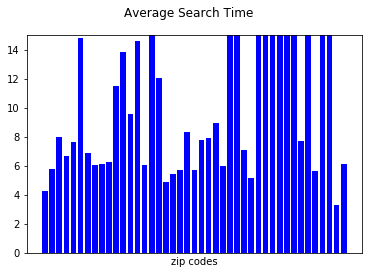

In [16]:
search_info = search_dict(EXAMPLE_DATETIME)
make_bar_chart("Average Search Time", search_info,15)

##### Expected Fare Dictionary

Contains the expected fare a driver would receive from getting a trip at a given time by zone.
When the expected fare could not be calculated because there are no values 0 is returned.

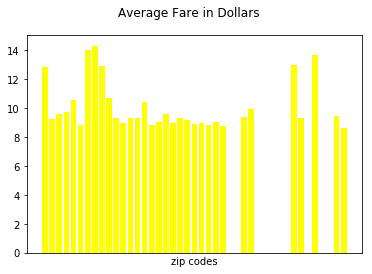

In [17]:
fare_info = fare_dict(EXAMPLE_DATETIME)
make_bar_chart("Average Fare in Dollars",fare_info, color='yellow')

##### Expected Distance to Other Zones Dictionary
Contains the expected travel time from a given zone to all other other zones at a given time.


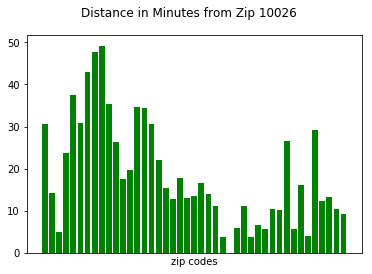

In [18]:
distance_info = distance_dict(EXAMPLE_ZIP_CODE, EXAMPLE_DATETIME,)
make_bar_chart("Distance in Minutes from Zip " + str(EXAMPLE_ZIP_CODE), distance_info, color='green')

##### Expected Trip Time Dictionary
Contains the expected customer journey time at a given time for all zones.

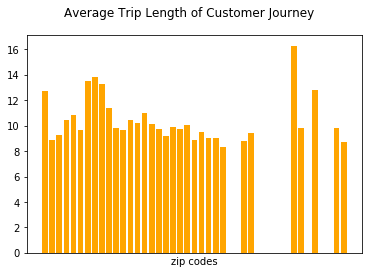

In [19]:
journey_info = journey_dict(EXAMPLE_DATETIME)
make_bar_chart("Average Trip Length of Customer Journey", journey_info, color='orange')

## Using Decision Function Delta in the simulation

Using these 4 dictionary functions we can now use our decision function to make decisions about where our taxi should move to.

In [20]:
# Example of Decision function class
delta = HighestEpm(search_dict, distance_dict, fare_dict, journey_dict).choose

earnings = taxi_env.run(EXAMPLE_ZIP_CODE, START_SHIFT, END_SHIFT, delta)

print("Driver spent " + str(earnings) + " minutes driving customers")

Driver spent 181.02580389305837 minutes driving customers


In [21]:
# Print drivers travel history
print("Driver starts in " + str(taxi_env.zip_code_travel_history[0]))
for i, code in enumerate(taxi_env.zip_code_travel_history[1:]):
    if i % 2:
        print("Customer picked up!")
        print("Customer dropped off at " + str( code))
    else:
        print("Driver searches in " + str(code))
print("End of Shift")
        
for time in taxi_env.time_history:
    print(time)

Driver starts in 10026
Driver searches in 10035
Customer picked up!
Customer dropped off at 10031
Driver searches in 10035
Customer picked up!
Customer dropped off at 10009
Driver searches in 10035
Customer picked up!
Customer dropped off at 10028
Driver searches in 10035
Customer picked up!
Customer dropped off at 10009
Driver searches in 10035
Customer picked up!
Customer dropped off at 10128
Driver searches in 10035
Customer picked up!
Customer dropped off at 10009
Driver searches in 10035
Customer picked up!
Customer dropped off at 10036
Driver searches in 10280
Customer picked up!
Customer dropped off at 10280
Driver searches in 10280
Customer picked up!
Customer dropped off at 10019
Driver searches in 10005
Customer picked up!
Customer dropped off at 10037
Driver searches in 10029
Customer picked up!
Customer dropped off at 10005
Driver searches in 10005
Customer picked up!
Customer dropped off at 10280
Driver searches in 10280
Customer picked up!
Customer dropped off at 10034
Dr

## Comparing our results to a typical Driver
Now we want to know how good our decision function is actually doing versus real world drivers in the data set.

For this we use the driver comparison class.

In [22]:
#Calculate comparison
#This may take some time to calculate
comparison_obj = DriverComparison()
comparison = comparison_obj.compare(START_SHIFT, END_SHIFT)
print("The typical taxi driver spent " + "{0:.2f}".format(comparison['average_drive_time']) + 
      " minutes with customers on the specified shift")
print(comparison)

The typical taxi driver spent 140.98 minutes with customers on the specified shift
{'medallions':                                   trip_time_in_secs  fare_amount
medallion                                                       
0554EEDB0E9A05B30CC37E3AFBEB5329               7620        119.0
06E904E035B1897C54F0C1AC30742E90               8040        124.0
132DCED0C0D70E6557992F9ED64A18D5              10320        154.0
13DAC9568B81600069B4738BAB2BF74D               6600         92.5
180EAF8CAD67959EC7BA02D8B2375F8B               7320        104.5
185D92FA910D5DD1EDCB3A231BEBE3AC               7740        122.5
1D8D3D3EE2B4AC3C6A244C5249801D93               8160        141.5
1F26E3AE395BA38401C36206E6DBEA34               7980        123.5
237A2696AB1B0BA9D4159E66B3809F2B               8820        140.0
262D41351DEDE03A185C78CFB51022C0               8580        145.0
26AAB74BA5054424019D80937927D17C               8520        119.5
290A68D0A2A5C668CA0BE410DB91DDCF               9000      

This graph shows the spread of time drivers spent with customers over the shift


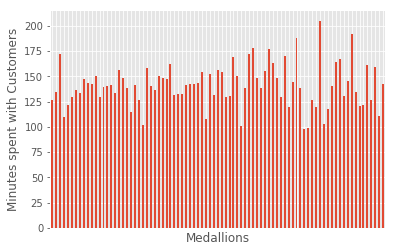

In [23]:
import matplotlib
matplotlib.style.use('ggplot')
(comparison['medallions']['trip_time_in_secs'] / 60).plot(kind = 'bar')
plt.tick_params(
axis='x',
which='both',
bottom='off',
top='off',
labelbottom='off') 
plt.xlabel('Medallions')
plt.ylabel('Minutes spent with Customers')
print("This graph shows the spread of time drivers spent with customers over the shift")
plt.show()



This graph shows the spread of money drivers earned over the course of the shift 


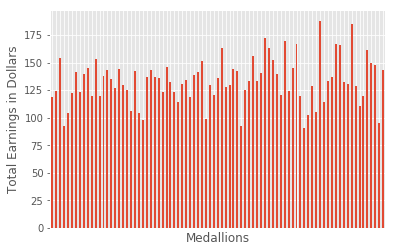

In [24]:
comparison['medallions']['fare_amount'].plot(kind = "bar")
plt.tick_params(
axis='x',
which='both',
bottom='off',
top='off',
labelbottom='off') 
plt.xlabel('Medallions')
plt.ylabel('Total Earnings in Dollars')
print("This graph shows the spread of money drivers earned over the course of the shift ")
plt.show()

This graph shows average driver earnings per minute over the course of the shift 


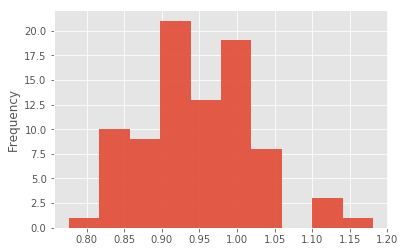

In [25]:
(comparison['medallions']['fare_amount'] 
 / (comparison['medallions']['trip_time_in_secs'] / 60)).plot.hist(alpha=0.9)
print("This graph shows average driver earnings per minute over the course of the shift ")
plt.show()

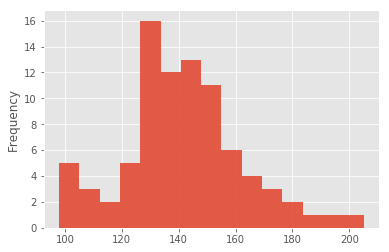

Frequency chart of earnings per shift


In [26]:
(comparison['medallions']['trip_time_in_secs'] / 60).plot.hist(alpha=0.9, bins= 15)
plt.show()
print("Frequency chart of earnings per shift")

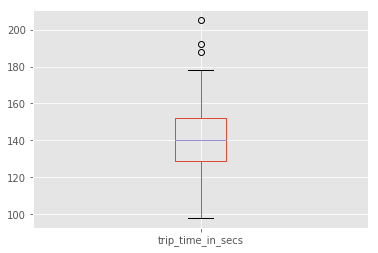

In [27]:
(comparison['medallions']['trip_time_in_secs'] / 60).plot.box()
plt.show()

#### Getting an average for our delta driver

We also need to get an average for our delta driver.

Average Stick or Twist performance - 168.0246618817287


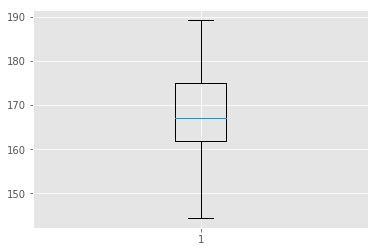

In [28]:
runs = 100
ave_minutes_sot = 0
sot_performance = []

for i in range(runs):
    sot_performance.append(taxi_env.run(EXAMPLE_ZIP_CODE, START_SHIFT, END_SHIFT, delta))
ave_minutes_sot = sum(sot_performance) / len(sot_performance)

print("Average Stick or Twist performance - " + str(ave_minutes_sot))

plt.boxplot(sot_performance)
plt.show()

In [29]:
#
change_percentage = ((ave_minutes_sot - comparison['average_drive_time']) / comparison['average_drive_time']) * 100
more_less = 'more' if change_percentage >= 0 else 'less'
print("Drivers using Stick or Twist spent " + "{0:.2f}".format(change_percentage) + "% " + more_less + " time driving with customers")

Drivers using Stick or Twist spent 19.19% more time driving with customers
